Rozwiązanie numeryczne


Rozpoczęcie symulacji dla T_max = 100.00 s...
Symulacja zakończona. Przetwarzanie wyników.


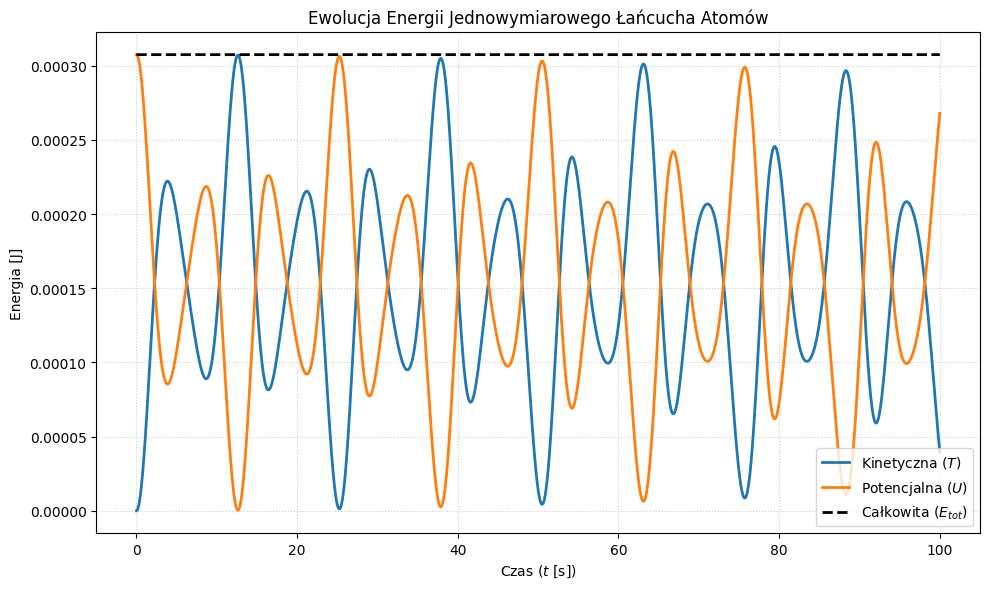

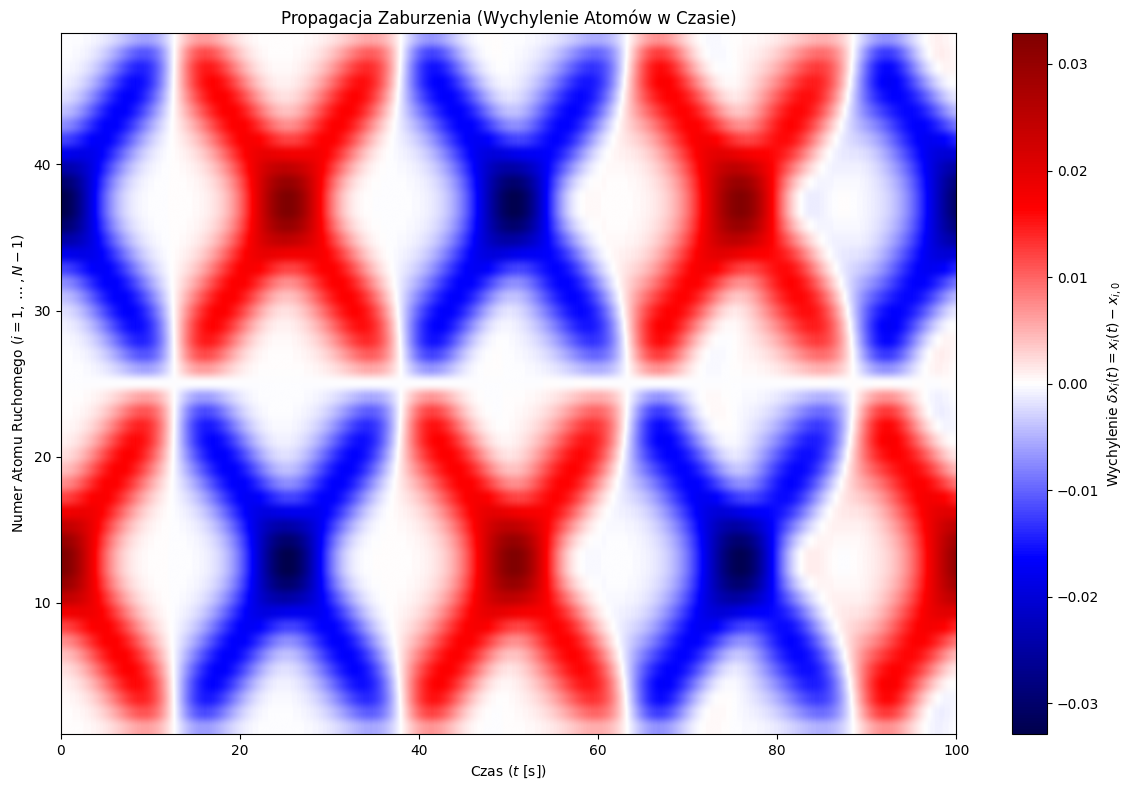

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. STAŁE FIZYCZNE I NUMERYCZNE ---
CONST = {
    "N": 50,
    "DELTA": 0.1,
    "ALPHA": 1.0,
    "M": 1.0,
    "DT": 0.02,
    "NT": 5000,
    "SIGMA": np.sqrt(0.1)
}
CONST["X_MAX"] = CONST["N"] * CONST["DELTA"]
CONST["T_MAX"] = CONST["NT"] * CONST["DT"]
CONST["N_INNER"] = CONST["N"] - 1
CONST["X_L"] = CONST["X_MAX"] / 4.0
CONST["X_R"] = 3.0 * CONST["X_MAX"] / 4.0


# --- 2. WARUNKI POCZĄTKOWE (POPRAWIONE) ---
def initial_conditions(N, DELTA, X_MAX, SIGMA):
    N_INNER = N - 1

    x_i_0 = np.arange(start=1, step=1, stop=N) * DELTA

    X_L = X_MAX / 4.0
    X_R = 3.0 * X_MAX / 4.0

    x_inner_0 = x_i_0[:N]

    # w funkcji Gaussa.
    gauss_L = (DELTA / 3.0) * np.exp(-((x_inner_0 - X_L)**2) / (2.0 * SIGMA**2))
    gauss_R = (DELTA / 3.0) * np.exp(-((x_inner_0 - X_R)**2) / (2.0 * SIGMA**2))

    x_init_inner = x_inner_0 + gauss_L - gauss_R

    v_init_inner = np.zeros(N_INNER)

    Y0 = np.concatenate([x_init_inner, v_init_inner])

    return Y0, x_i_0


# --- 3. FUNKCJA DYNAMIKI (PRAWA STRONA RRZ) ---
def dynamics_function(Y, t, ALPHA, M, N, DELTA):
    N_INNER = N - 1

    X_inner = Y[:N_INNER]
    V_inner = Y[N_INNER:]

    X_MAX = N * DELTA
    x0 = 0.0
    xN = X_MAX

    X_all = np.concatenate([[x0], X_inner, [xN]])

    dXd_dt = V_inner

    dVd_dt = np.zeros(N_INNER)

    for i in range(N_INNER):
        x_minus_1 = X_all[i]
        x_i = X_all[i + 1]
        x_plus_1 = X_all[i + 2]

        dVd_dt[i] = (ALPHA / M) * (x_minus_1 - 2.0 * x_i + x_plus_1)

    dYdt = np.concatenate([dXd_dt, dVd_dt])

    return dYdt


# --- 4. FUNKCJA OBLICZANIA ENERGII ---
def calculate_energy(Y, X_i_0, ALPHA, M, N, DELTA):
    N_INNER = N - 1

    X_inner = Y[:N_INNER]
    V_inner = Y[N_INNER:]

    X_MAX  = N * DELTA
    x0 = 0.0
    xN = X_MAX


    T = 0.5 * M * np.sum(V_inner**2)


    X_all = np.concatenate([[x0], X_inner, [xN]])
    diff = X_all[:-1] - X_all[1:]


    U = 0.5 * ALPHA * np.sum((diff + DELTA)**2)


    return T, U

# --- 5. GŁÓWNA PĘTLA SYMULACYJNA ---

# Inicjalizacja
Y0, X_i_0_eq = initial_conditions(CONST["N"], CONST["DELTA"], CONST["X_MAX"], CONST["SIGMA"])
Y = Y0.copy()

# Zmienne do przechowywania wyników
Times = np.linspace(0, CONST["T_MAX"], CONST["NT"] + 1)
Energy_K = []
Energy_P = []
Displacement_Matrix = []


# Zapis stanu początkowego
# Zmieniono X_i_0 na X_i_0_eq
T, U = calculate_energy(Y, X_i_0_eq, CONST["ALPHA"], CONST["M"], CONST["N"], CONST["DELTA"])
Energy_K.append(T)
Energy_P.append(U)
X_inner_current = Y[:CONST["N_INNER"]]
delta_X_current = X_inner_current - X_i_0_eq[:CONST["N"]]
Displacement_Matrix.append(delta_X_current.copy())


print(f"Rozpoczęcie symulacji dla T_max = {CONST['T_MAX']:.2f} s...")

# Pętla RK4
for n in range(CONST["NT"]):
    t = Times[n]
    dt = CONST["DT"]

    # Użycie funkcji anonimowej (lambda) do przekazania stałych do funkcji dynamiki
    func = lambda t, Y_vec: dynamics_function(Y_vec, t, CONST["ALPHA"], CONST["M"], CONST["N"], CONST["DELTA"])

    # Kroki Rungego-Kutty 4. rzędu
    k1 = func(t, Y)
    k2 = func(t + 0.5 * dt, Y + 0.5 * dt * k1)
    k3 = func(t + 0.5 * dt, Y + 0.5 * dt * k2)
    k4 = func(t + dt, Y + dt * k3)

    # Obliczenie nowego stanu
    Y = Y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

    # Zapis danych
    T, U = calculate_energy(Y, X_i_0_eq, CONST["ALPHA"], CONST["M"], CONST["N"], CONST["DELTA"])
    Energy_K.append(T)
    Energy_P.append(U)

    # Zapis wychyleń: delta_x_i(t) = x_i(t) - x_i,0
    X_inner_current = Y[:CONST["N_INNER"]]
    delta_X_current = X_inner_current - X_i_0_eq
    Displacement_Matrix.append(delta_X_current.copy())


print("Symulacja zakończona. Przetwarzanie wyników.")

Energy_K = np.array(Energy_K)
Energy_P = np.array(Energy_P)

# Energy_P = Energy_P/max(Energy_P) * 0.007
# Energy_K = Energy_K/max(Energy_K) * 0.007

Energy_Total = Energy_K + Energy_P

Displacement_Matrix = np.array(Displacement_Matrix) # Wymiar: (N_t + 1) x (N_INNER)




# --- 6. WIZUALIZACJA WYNIKÓW ---
plt.figure(figsize=(10, 6))
plt.plot(Times, Energy_K, label='Kinetyczna ($T$)', linewidth=2)
plt.plot(Times, Energy_P, label='Potencjalna ($U$)', linewidth=2)
plt.plot(Times, Energy_Total, label='Całkowita ($E_{tot}$)', linestyle='--', color='k', linewidth=2)

plt.title('Ewolucja Energii Jednowymiarowego Łańcucha Atomów')
plt.xlabel('Czas ($t$ [s])')
plt.ylabel('Energia [J]')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(
    Displacement_Matrix.T,
    aspect='auto',
    origin='lower',
    extent=[Times.min(), Times.max(), 1, CONST["N_INNER"]],
    cmap='seismic',
    vmax=np.max(Displacement_Matrix),
    vmin=np.min(Displacement_Matrix)
)

plt.colorbar(label='Wychylenie $\\delta x_i(t) = x_i(t) - x_{i,0}$ ')
plt.title('Propagacja Zaburzenia (Wychylenie Atomów w Czasie)')
plt.xlabel('Czas ($t$ [s])')
plt.ylabel('Numer Atomu Ruchomego ($i=1, \\dots, N-1$)')
plt.tight_layout()
plt.show()
